In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et
import xarray as xr
import regionmask

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

In [4]:
# read the nc file and the shapefile according to the extent of bbox

nc_path = r'C:\Users\kizar\data\download.nc'
with xr.open_dataset(nc_path) as file_nc:
    lon_min = file_nc.longitude.min().item()
    lon_max = file_nc.longitude.max().item()
    lat_min = file_nc.latitude.min().item()
    lat_max = file_nc.latitude.max().item()

# View xarray object
t2m = file_nc

# Define the extent as a tuple
extent = (lon_min, lon_max, lat_min, lat_max)
shape_path = r'C:\Users\kizar\OneDrive - Universität Salzburg\Desktop\ERASMUS\Salzburg_sem2\Software_development\Final_project\PRT_adm\PRT_adm0.shp'
# Use geopandas to read the shapefile based on the extent
gdf = gpd.read_file(shape_path, bbox=extent)

# Print the GeoDataFrame or perform further operations with it
gdf

,ID_0,ISO,NAME_0,OBJECTID_1,ISO3,NAME_ENGLI,NAME_ISO,NAME_FAO,NAME_LOCAL,NAME_OBSOL,...,CARICOM,EU,CAN,ACP,Landlocked,AOSIS,SIDS,Islands,LDC,geometry
0,182,PRT,Portugal,185,PRT,Portugal,PORTUGAL,Portugal,Portugal,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-16.05835 30.03020, -16.05837 ..."


In [35]:
t2m

<xarray.Dataset>
Dimensions:    (longitude: 143, latitude: 61, time: 8760)
Coordinates:
  * longitude  (longitude) float32 -14.19 -13.94 -13.69 ... 20.81 21.06 21.31
  * latitude   (latitude) float32 48.38 48.13 47.88 47.63 ... 33.88 33.63 33.38
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-05 11:17:22 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [5]:
# You will use the bounds to determine the slice values for this data
porto_aoi = gdf[gdf.NAME_0 == 'Portugal' ]
# Get the total spatial extent for California
porto_aoi.total_bounds
porto_aoi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# Get lat min, max
aoi_lat = [float(porto_aoi.total_bounds[3]), float(porto_aoi.total_bounds[1])]
aoi_lon = [float(porto_aoi.total_bounds[0]), float(porto_aoi.total_bounds[2])]
# Notice that the longitude values have negative numbers
# we need these values in a global crs so we can subtract from 360
aoi_lat, aoi_lon

([42.15431594848633, 30.03017616271984],
 [-31.26818656921381, -6.189142227172852])

In [7]:
start_date = "2022-01-01"
end_date = "2022-01-01"

data_slice = t2m["t2m"].sel(
    time=slice(start_date, end_date),
    longitude=slice(aoi_lon[0], aoi_lon[1]),
    latitude=slice(aoi_lat[0], aoi_lat[1]))
data_slice

<xarray.DataArray 't2m' (time: 24, latitude: 36, longitude: 33)>
[28512 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -14.19 -13.94 -13.69 ... -6.69 -6.44 -6.19
  * latitude   (latitude) float32 42.13 41.88 41.63 41.38 ... 33.88 33.63 33.38
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-01-01T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

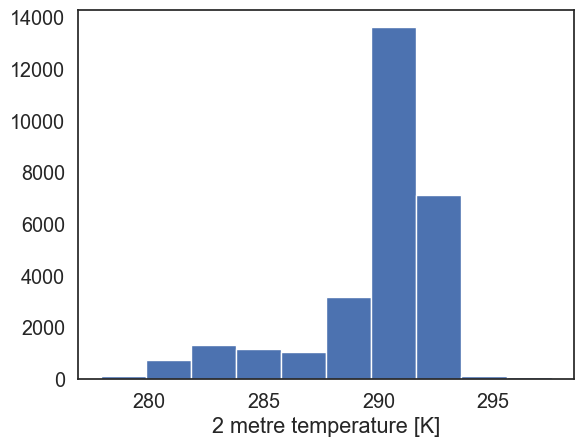

In [8]:
data_slice.plot()
plt.show()

In [9]:
# Spatial Plot for the selected AOI (California)
# data_slice.plot(col='time',
#                      col_wrap=1)

# plt.show()

porto_ts = t2m["t2m"].sel(
    longitude=slice(aoi_lon[0], aoi_lon[1]),
    latitude=slice(aoi_lat[0], aoi_lat[1]))
porto_ts
porto_ts_daily_max = porto_ts.groupby('time.month').max(skipna=True)
porto_ts_daily_max

porto_ts_daily_max_val = porto_ts_daily_max.groupby("month").max(["latitude", "longitude"])
porto_ts_daily_max_val





<xarray.DataArray 't2m' (month: 12)>
array([298.2215 , 302.22287, 299.0792 , 304.21808, 314.6552 , 314.373  ,
       317.5361 , 314.68198, 310.20615, 308.3764 , 302.50998, 297.90274],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:      K
    long_name:  2 metre temperature

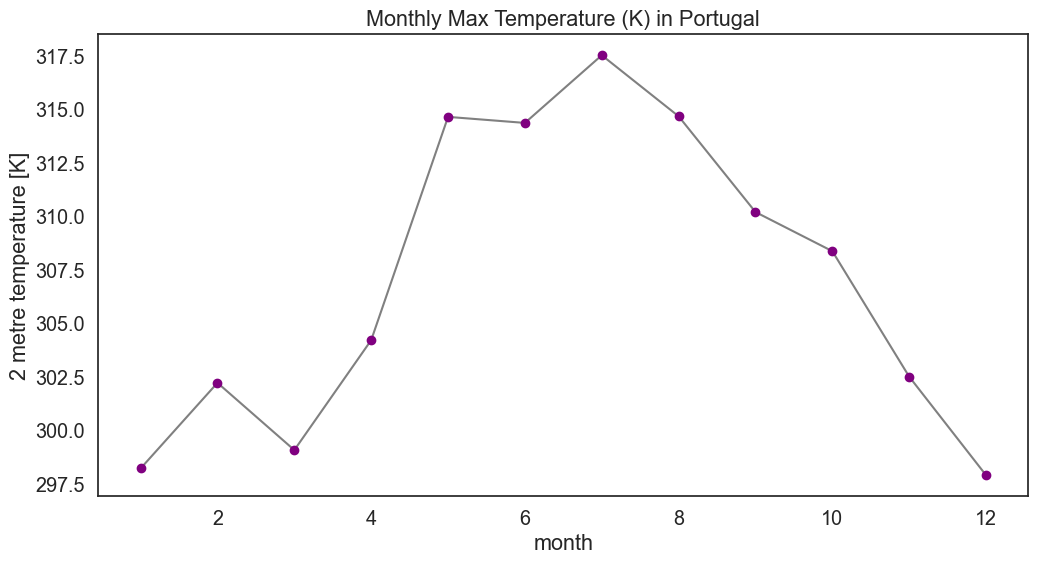

In [10]:
# Plot the data
f, ax = plt.subplots(figsize=(12, 6))
porto_ts_daily_max_val.plot.line(hue='lat',
                              marker="o",
                              ax=ax,
                              color="grey",
                              markerfacecolor="purple",
                              markeredgecolor="purple")
ax.set(title="Monthly Max Temperature (K) in Portugal")
plt.show()

## Subset a netcdf4 Using a Shapefile Feature or Features



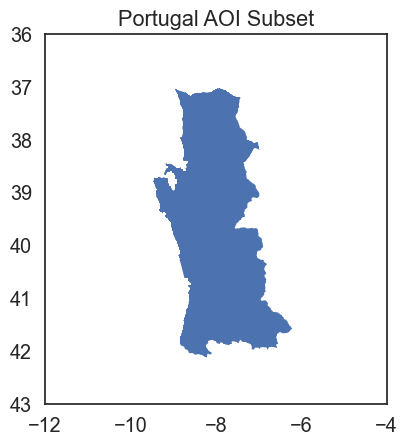

In [11]:
ymin = 43
ymax = 36
xmin = -12
xmax = -4
# Assuming you have the extent of your AOI as xmin, xmax, ymin, ymax
#xmin, xmax, ymin, ymax = your_extent_values  # Replace with your actual extent values

# Create a subplot
f, ax = plt.subplots()

# Plot your data
porto_aoi.plot(ax=ax)

# Set the limits to zoom and center the plot
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Set the plot title
ax.set_title("Portugal AOI Subset")

# Show the plot
plt.show()


c:\Users\kizar\anaconda3\envs\era5\Lib\site-packages\regionmask\core\plot.py:232: FutureWarning: 'proj' has been renamed to 'projection'
  warnings.warn("'proj' has been renamed to 'projection'", FutureWarning)


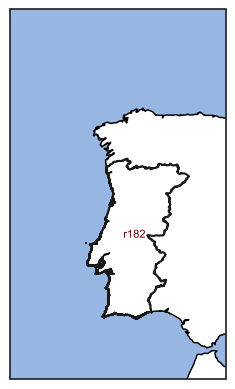

In [12]:
import cartopy.crs as ccrs
import matplotlib.patheffects as pe

region = regionmask.from_geopandas(porto_aoi,
                                    numbers='ID_0',
                                    names='NAME_0',
                                   	name = 'region')


# Define the WGS 84 projection
proj = ccrs.PlateCarree()
text_kws = dict(
    bbox=dict(color="none"),
    path_effects=[pe.withStroke(linewidth=2, foreground="w")],
    color="#67000d",
    fontsize=8,
)
ax = region.plot(
    add_ocean=True,
    resolution="50m",
    proj=proj,
    label="abbrev",
    text_kws=text_kws,
)

# Fine-tune the extent in WGS 84
ax.set_extent([-5, -12, 47, 35], crs=proj)

# Add coastlines
ax.coastlines()

# Show the plot
plt.show()


In [13]:
# Create a 3d mask - this contains the true / false values identifying pixels
# inside vs outside of the mask region
porto_mask = regionmask.mask_3D_geopandas(porto_aoi,
                                         porto_ts_daily_max.longitude,
                                         porto_ts_daily_max.latitude)
porto_mask

<xarray.DataArray 'mask' (region: 1, latitude: 36, longitude: 33)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True,  True, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * latitude   (latitude) float32 42.13 41.88 41.63 41.38 ... 33.88 33.63 33.38
  * longitude  (longitude) float32 -14.19 -13.94 -13.69 ... -6.69 -6.44 -6.19
  * region     (region) int32 0
Attributes:
    standard_name:  region

In [14]:
# Slice out two months of data
monthly_porto = porto_ts_daily_max_val.sel(
    month =slice(1, 12))

In [15]:
# Apply the mask for California to the data
monthly_porto = monthly_porto.where(porto_mask)
monthly_porto

<xarray.DataArray 't2m' (month: 12, region: 1, latitude: 36, longitude: 33)>
array([[[[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ..., 298.2215 ,       nan,
                nan],
         [      nan,       nan,       nan, ..., 298.2215 , 298.2215 ,
                nan],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]]],


       [[[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ..., 302.22287,       nan,
                nan],
         [      nan,       nan,       nan, ..., 302.22287, 302.22287,
...
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]]],


       [[[      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ..., 297.90274,       nan,
                nan],
         [      nan,       nan,       nan, ..., 297.90274, 297.90274,
                nan],
         ...,
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan],
         [      nan,       nan,       nan, ...,       nan,       nan,
                nan]]]], dtype=float32)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float32 42.13 41.88 41.63 41.38 ... 33.88 33.63 33.38
  * longitude  (longitude) float32 -14.19 -13.94 -13.69 ... -6.69 -6.44 -6.19
  * region     (region) int32 0
Attributes:
    units:      K
    long_name:  2 metre temperature

In [16]:
dataset = monthly_porto.to_dataset(name='t2m')
dataset


<xarray.Dataset>
Dimensions:    (month: 12, latitude: 36, longitude: 33, region: 1)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float32 42.13 41.88 41.63 41.38 ... 33.88 33.63 33.38
  * longitude  (longitude) float32 -14.19 -13.94 -13.69 ... -6.69 -6.44 -6.19
  * region     (region) int32 0
Data variables:
    t2m        (month, region, latitude, longitude) float32 nan nan ... nan nan

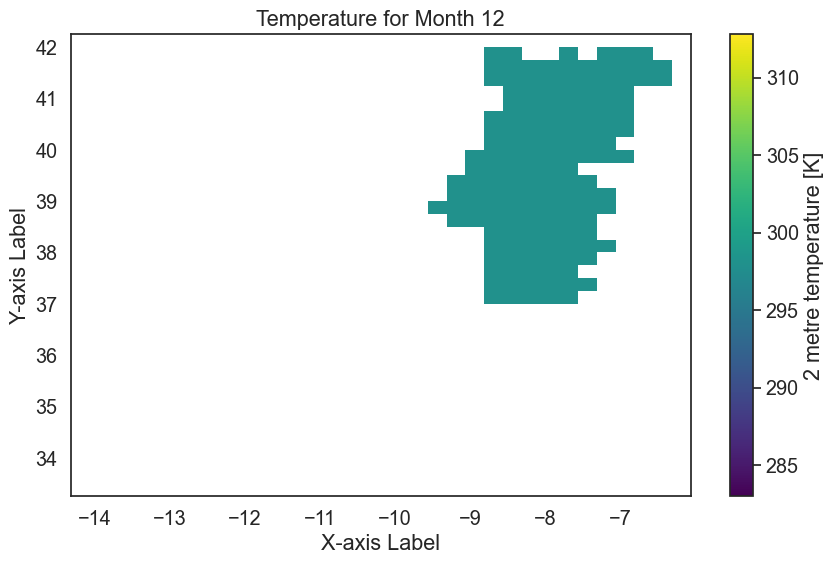

In [24]:

# Assuming you have a Dataset named 'dataset' with a variable 't2m' and a 'month' coordinate.

def plot_temperature_for_month(dataset, month):
    if 1 <= month <= 12:
        selected_data = dataset.sel(month=month)
        selected_data['t2m'].plot(figsize=(10, 6))
        plt.title(f'Temperature for Month {month}')
        plt.xlabel('X-axis Label')
        plt.ylabel('Y-axis Label')
        plt.show()
    else:
        print("Invalid month. Please enter a value between 1 and 12.")

# Get user input for the month (1 to 12)
month = int(input("Enter a month (1 to 12): "))
plot_temperature_for_month(dataset, month)


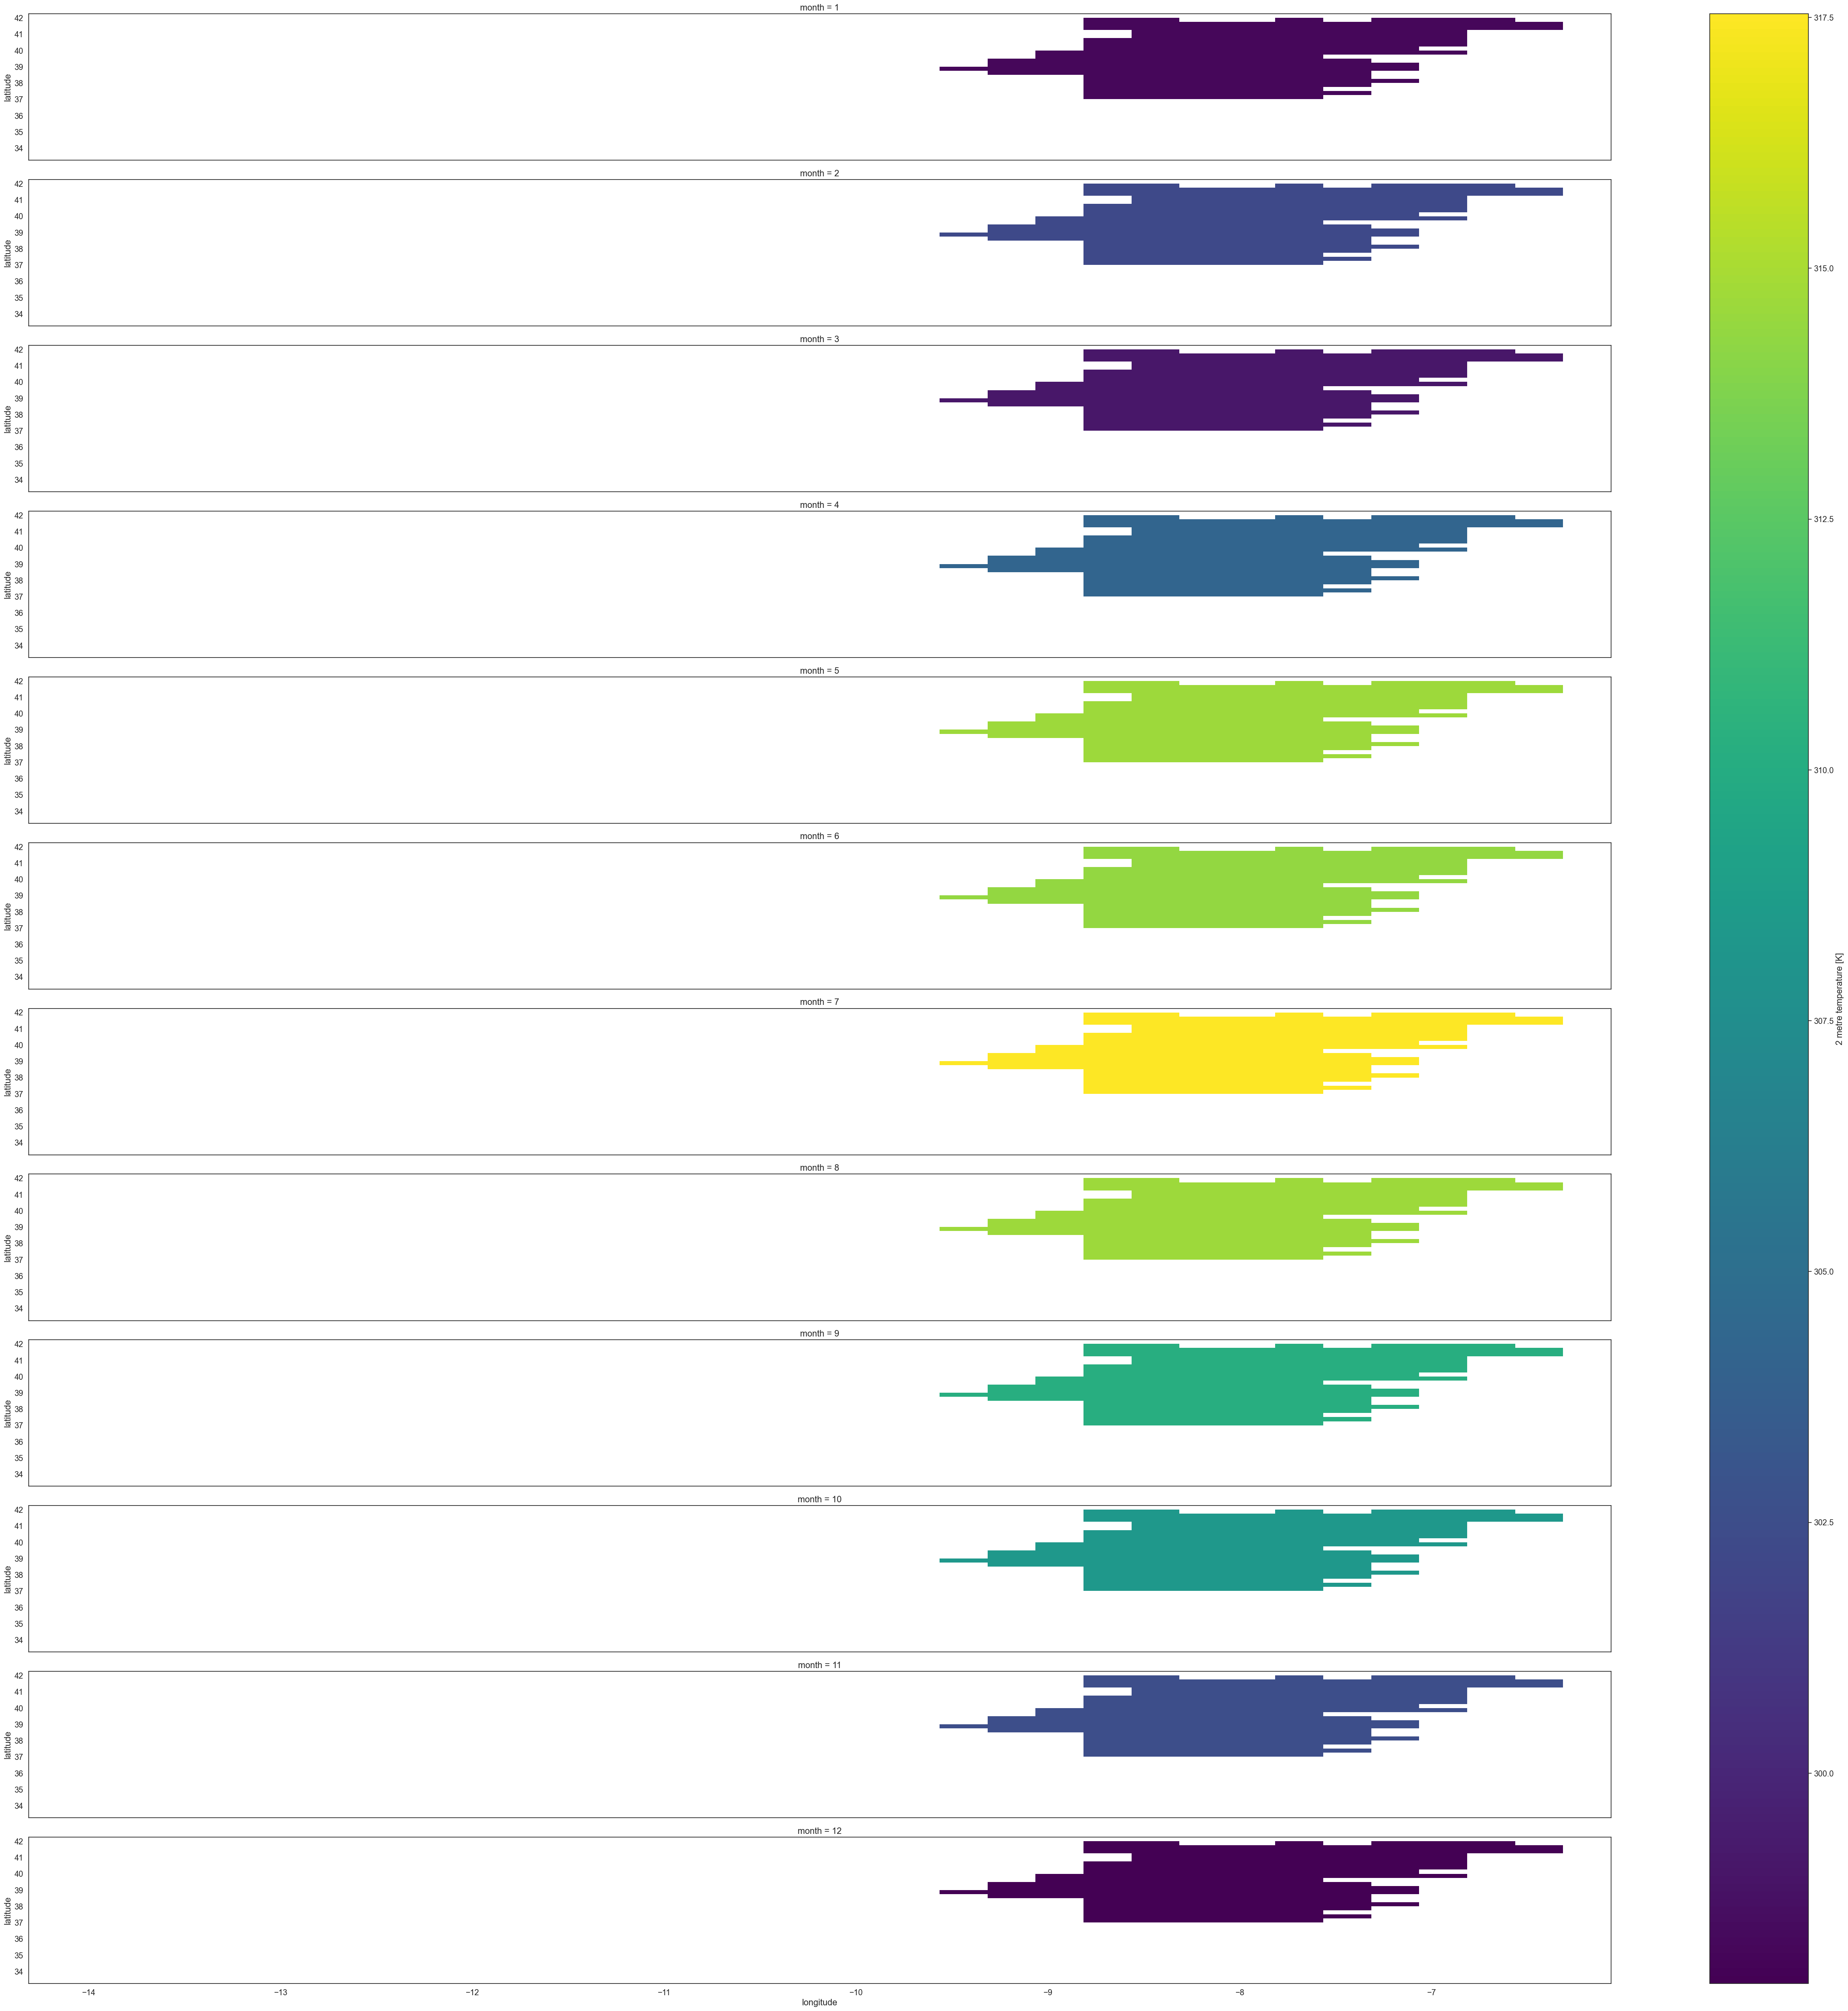

In [18]:
dataset['t2m'].plot(col='month',
                    col_wrap=1,
                    figsize=(50, 50))
plt.show()